# **Import Libraries**

In [ ]:
!pip install --upgrade pandas
!pip install matplotlib
!pip install --upgrade statsmodels

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math

from torch.utils.data import DataLoader, Dataset
from numpy import array
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# **Time Series Forecasting (Transformers)**

**Mengimpor Dataset dari Google Drive**

In [ ]:
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 --index-url https://download.pytorch.org/whl/cu113
!pip install torchcam==0.3.1
!pip install bertviz

import pandas as pd
from google.colab import drive

date_parser = lambda x: pd.to_datetime(x, format='%d/%m/%Y')
drive.mount('/content/drive')
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv', delimiter=';')
#dataset = /content/Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv
print(dataset.dtypes)
# Display the first few rows of the dataset
print(dataset.head())

# Display the column names of the dataset
print(dataset.columns)

# Untuk memeriksa nilai NaN
print(dataset.isna().sum())

dataset = dataset.dropna()

# Display the column names of the dataset
print(dataset.isna().sum())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Looking in indexes: https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu121
    Uninstalling torchaudio-2.5.1+cu121:
      Successfully uninstalled torchaudio-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

**Model Transformers**

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#!pip install torch torchvision torchaudio
import copy
from typing import Optional, Any, Union, Callable
import torch.nn as nn
import math
import torch
from torch import Tensor
from torch.nn import functional as F
from torch.nn import Module
from torch.nn import MultiheadAttention
from torch.nn import ModuleList
from torch.nn.init import xavier_uniform_
from torch.nn import Dropout
from torch.nn import Linear
from torch.nn import LayerNorm

class TransformerEncoderLayer(nn.Module):

    __constants__ = ['batch_first', 'norm_first']

    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 512, dropout: float = 0.2,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-4, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first, **factory_kwargs)
        print(f"Number of heads: {nhead}")

        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = Dropout(dropout, inplace=True)
        self.linear2 = Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = Dropout(dropout, inplace=True)
        self.dropout2 = Dropout(dropout, inplace=True)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            self.activation = _get_activation_fn(activation)
        else:
            self.activation = activation

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        x = src
        #print(f"Bentuk input tensor sebelum attention: {x.size()}")  # Tambahkan print statement di sini
        #print(f"Input shape before any layers: {x.shape}")

        if self.norm_first:
            x, attn_weights = self._sa_block(self.norm1(x), src_mask, src_key_padding_mask)
            x = x + self._ff_block(self.norm2(x))
        else:
            x, attn_weights = self._sa_block(x, src_mask, src_key_padding_mask)
            x = self.norm1(x + self._ff_block(x))

        #print(f"Bentuk output tensor setelah attention: {x.size()}")  # Tambahkan print statement di sini
        #print(f"Bentuk tensor attention: {attn_weights.size()}")  # Tambahkan print statement di sini
        #print(f"Output shape after all layers: {x.shape}")

        return x, attn_weights

    # self-attention block
    def _sa_block(self, x: Tensor, attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x, attn_weights = self.self_attn(x, x, x, attn_mask=attn_mask, key_padding_mask=key_padding_mask, need_weights=True)
        #print(f"Bentuk tensor attention dalam _sa_block: {attn_weights.size()}")  # Tambahkan print statement di sini
        return self.dropout1(x), attn_weights

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.activation(self.linear1(x)))
        return self.dropout2(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len_positional_encoding):
        super(PositionalEncoding, self).__init__()
        max_len = max_len_positional_encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(max_len_positional_encoding) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)  # Sequence length adalah dimensi kedua
        print("Shape of x:", x.shape)
        print("Shape of self.pe:", self.pe.shape)
        x = x + self.pe[:seq_len, :]
        return x


class aletheia_UNet(nn.Module):
    def __init__(self, nhidden, num_layers, nhead, dropout, in_channels, out_channels, max_len_positional_encoding, number_of_cols, output_attentions=False):
        super(aletheia_UNet, self).__init__()
        self.model_type = 'Transformer for Time Series Forecasting'
        self.nhidden = nhidden
        self.num_layers = num_layers
        self.nhead = nhead
        self.dropout = dropout
        self.in_channels = in_channels * number_of_cols
        self.out_channels = out_channels
        self.max_len_positional_encoding=max_len_positional_encoding
        self.number_of_cols = number_of_cols
        self.src_mask = None
        self.output_attentions = output_attentions  # Simpan nilai
        self.pos_encoder = PositionalEncoding(nhidden,max_len_positional_encoding)
        self.final_layer = nn.Linear(nhidden, number_of_cols)

        self.encoder_layer = TransformerEncoderLayer(d_model=nhidden, nhead=nhead, dropout=dropout, dim_feedforward=256, layer_norm_eps=1e-6)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(nhidden, number_of_cols)
        self.init_weights()

        self.conv1 = self.contract_block(self.in_channels, 24, 3, 1)
        self.conv2 = self.contract_block(24, 48, 3, 1)
        self.conv3 = self.contract_block(48, 72, 3, 1)
        self.conv4 = self.contract_block(72, 96, 3, 1)

        self.upconv4 = self.expand_block(96, 72, 3, 1)
        self.upconv3 = self.expand_block(72 * 2, 48, 3, 1)
        self.upconv2 = self.expand_block(48 * 2, 24, 3, 1)
        self.upconv1 = self.expand_block(24 * 2, self.out_channels, 3, 1)

    def init_weights(self):
        initrange = 0.01
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output, attn_weights = self.transformer_encoder(src, self.src_mask)
        #print(f"Size after Transformer Encoder: {output.size()}")

        ### Begin of the U-net block
        output = torch.reshape(output, (output.shape[1], output.shape[0], output.shape[2]))

        conv1 = self.conv1(output)
        #print(f"Size after conv1: {conv1.size()}")
        conv2 = self.conv2(conv1)
        #print(f"Size after conv2: {conv2.size()}")
        conv3 = self.conv3(conv2)
        #print(f"Size after conv3: {conv3.size()}")
        conv4 = self.conv4(conv3)
        #print(f"Size after conv4: {conv4.size()}")

        upconv4 = self.upconv4(conv4)
        #print(f"Size after upconv4: {upconv4.size()}")
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        #print(f"Size after upconv3: {upconv3.size()}")
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        #print(f"Size after upconv2: {upconv2.size()}")
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        #print(f"Size after upconv1: {upconv1.size()}")

        upconv1 = torch.reshape(upconv1, (upconv1.shape[1], upconv1.shape[0], upconv1.shape[2]))
        ### End of the U-net block

        output = self.decoder(upconv1)
        #print(f"Size after decoder: {output.size()}")
        return output, attn_weights  # Mengembalikan dua nilai

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            torch.nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.ReLU(),
            #torch.nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            torch.nn.Dropout(p=0.3, inplace=True)
        )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            #torch.nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Dropout(p=0.3, inplace=True)
        )
        return expand


class aletheia_noUNet(nn.Module):
    def __init__(self, nhidden, num_layers, nhead, dropout, in_channels, out_channels, max_len_positional_encoding, number_of_cols, output_attentions=False):
        super(aletheia_noUNet, self).__init__()
        self.model_type = 'Transformer for Time Series Forecasting'
        self.nhidden = nhidden
        self.num_layers = num_layers
        self.nhead = nhead
        self.dropout = dropout
        self.in_channels = in_channels * number_of_cols
        self.out_channels = out_channels
        self.max_len_positional_encoding=max_len_positional_encoding
        self.number_of_cols = number_of_cols
        self.src_mask = None
        self.output_attentions = output_attentions  # Simpan nilai
        self.pos_encoder = PositionalEncoding(nhidden,max_len_positional_encoding)

        self.encoder_layer = TransformerEncoderLayer(d_model=nhidden, nhead=nhead, dropout=dropout, dim_feedforward=256, layer_norm_eps=1e-6)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(nhidden, number_of_cols)
        self.init_weights()

    def init_weights(self):
        initrange = 0.01
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output, attn_weights = self.transformer_encoder(src, self.src_mask)

        output = self.decoder(output)
        return output, attn_weights  # Mengembalikan output dan peta perhatian

    def _generate_square_subsequent_mask(self, ss):
        mask = (torch.triu(torch.ones(ss, ss)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

class aletheia_noUNet_mul(nn.Module):
    def __init__(self, nhidden, num_layers, nhead, dropout, in_channels, out_channels, max_len_positional_encoding, number_of_cols, output_attentions=False):
        super(aletheia_noUNet, self).__init__()
        self.model_type = 'Transformer for Time Series Forecasting'
        self.nhidden = nhidden
        self.num_layers = num_layers
        self.nhead = nhead
        self.dropout = dropout
        self.in_channels = in_channels * number_of_cols
        self.out_channels = out_channels
        self.max_len_positional_encoding=max_len_positional_encoding
        self.number_of_cols = number_of_cols
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(nhidden,max_len_positional_encoding)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=nhidden, nhead=nhead, dropout=dropout, dim_feedforward=128, layer_norm_eps=1e-6)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(nhidden, number_of_cols)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output, attn_weights = self.transformer_encoder(src, self.src_mask)

        output = self.decoder(output)
        return output, attn_weights  # Mengembalikan output dan peta perhatian

    def _generate_square_subsequent_mask(self, ss):
        mask = (torch.triu(torch.ones(ss, ss)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

**Prosedur Train & Test Dataset**

In [ ]:
import time
import torch

calculate_loss_over_all_values = False

def get_batch_mul(source, i, batch_size, input_window, number_of_cols):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i + seq_len]
    observation = torch.stack(
        torch.stack([item[0] for item in data]).chunk(input_window*number_of_cols, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window*number_of_cols, 1))
    #print(f"Shape of observation: {observation.shape}")
    #print(f"Shape of target: {target.shape}")

    return observation, target

def train_mul(model, optimizer, criterion, scheduler, clip_grad_norm, train_data, batch_size, epoch, epochs, input_window, output_window, number_of_cols, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch_mul(train_data, i, batch_size, input_window, number_of_cols)

        output, attn_weights = model(data)  # Menggunakan output dan peta perhatian

        # Simpan peta perhatian untuk visualisasi
        if batch == 0:
            attention_maps = attn_weights

        targets_temp = torch.zeros([output_window, batch_size, number_of_cols], device=device)
        for j in reversed(range(output_window)):
            targets_temp[-j + output_window - 1] = targets[-j * number_of_cols - 1]

        #print(f"Output size: {output.size()}, Target size: {targets_temp.size()}")
        #print(f"Shape of output: {output.shape}")
        #print(f"Shape of targets_temp: {targets_temp.shape}")
        #print(f"Number of elements in output: {output.nelement()}")
        #print(f"Number of elements in targets_temp: {targets_temp.nelement()}")

        # if output.shape != targets_temp.shape: raise ValueError(f"Output shape
        # {output.shape} does not match target shape {targets_temp.shape}")

        # Pastikan ukuran tensor sesuai
        #if output.size() != targets_temp.size():
        #    output = output.view_as(targets_temp)

        if calculate_loss_over_all_values:
            loss = criterion(output, targets_temp)
        else:
            loss = criterion(output[-output_window:], targets_temp[-output_window:])

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm, norm_type=2.0)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 2)  # / 5
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d}/{} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:6.2f} ms | '
                  'train loss {:5.5f}'.format(
                epoch, epochs, batch, len(train_data) // batch_size, scheduler.get_last_lr()[0],
                                      elapsed * 1000 / log_interval,
                cur_loss))
            total_loss = 0.0
            start_time = time.time()

    return attention_maps  # Mengembalikan peta perhatian untuk visualisasi

def evaluate_mul(eval_model, criterion, data_source,batch_size, input_window, output_window, number_of_cols, device):
    eval_model.eval()
    total_loss = 0.0
    eval_batch_size = batch_size
    attention_maps = None  # Inisialisasi peta perhatian
    with torch.inference_mode():
        for batch, i in enumerate(range(0, len(data_source) - 1, eval_batch_size)):
            data, targets = get_batch_mul(data_source, i, eval_batch_size, input_window, number_of_cols)
            output, attn_weights = eval_model(data)  # Menggunakan output dan peta perhatian

            # Simpan peta perhatian untuk visualisasi
            if batch == 0:
                attention_maps = attn_weights

            targets_temp = torch.zeros([output_window, eval_batch_size, number_of_cols], device=device)
            for j in reversed(range(output_window)):
                targets_temp[-j + output_window - 1] = targets[-j * number_of_cols - 1]

            # Pastikan ukuran tensor sesuai
            #if output.numel() == targets_temp.numel():
            #    output = output.view_as(targets_temp)
            #else:
                #print(f"Ukuran tensor output: {output.size()}, Ukuran tensor targets_temp: {targets_temp.size()}")
            #    raise ValueError("Ukuran tensor output dan targets_temp tidak sesuai")

            if calculate_loss_over_all_values:
                total_loss += len(data[0]) * criterion(output, targets_temp).cpu().item()
            else:
                total_loss += len(data[0]) * criterion(output[-output_window:], targets_temp[-output_window:]).cpu().item()

    return total_loss / len(data_source)



**Data Loader**

In [ ]:
def create_inout_sequences_mul(input_data, input_label, input_window, output_window, number_of_cols):
    import numpy as np
    import torch
    inout_seq = []
    L = len(input_label)
    print(f"L inoutseq: {L}")
    print(f"number_of_cols inoutseq: {number_of_cols}")
    print(f"Shape of input_data: {input_data.shape}")  # Tambahkan untuk melihat bentuk data awal


    for i in range(L - input_window):
        input_data_loop = input_data[i*number_of_cols:i*number_of_cols + input_window*number_of_cols]
        #print(f"Shape of input_data_loop: {input_data_loop.shape}")
        #print(f"First few rows of input_data_loop:\n{input_data_loop[:5]}")

        train_seq = np.append(input_data_loop[:-output_window*number_of_cols], output_window * number_of_cols * [0])
        train_label = np.repeat(input_label[i:i + input_window],number_of_cols)

        for k in range(len(train_label)):
            if k !=0 and k % number_of_cols != 0:
                train_label[k-1] = 0
        inout_seq.append((train_seq, train_label))

    np_array = np.array(inout_seq)
    print(f"Shape of np_array after conversion: {np_array.shape}")  # Should reflect the correct use of features
    return torch.FloatTensor(np_array)



def get_aletheia_data(dataset, target, input_window, output_window, device, number_of_cols):
    from pandas import read_csv
    dataset = dataset
    target=target
    input_window = input_window
    output_window = output_window
    device = device
    number_of_cols = number_of_cols

    series = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv', delimiter=';', header=0, index_col=0, parse_dates=True, dayfirst=True)

    # Drop rows with missing values
    series = series.dropna()

    # Convert non-numeric columns to numeric representations
    for col in series.columns:
        if series[col].dtype == 'object':
            series[col] = series[col].astype('category').cat.codes

    # Display the first few rows of the dataset
    print(series.head())
    print("Fitur:", series.columns)
    print("===================================")
    #print(f"Fitur yang digunakan: {features}")
    print(f"Bentuk data setelah pemuatan: {series.shape}")
    print(f"Jumlah kolom yang digunakan: {number_of_cols}")  # Harus output 6
    print("===================================")

    # Function to handle negative values for log transformation
    def handle_negative_values_for_log(series):
        for column in series.columns:
            min_value = series[column].min()
            if min_value < 0:
                series.loc[:, column] = series[column] - min_value + 1
            elif min_value == 0:
                series.loc[:, column] = series[column] + 1
        return series

    # Handle negative values and apply Log Transformation to the selected columns
    columns_to_transform = ['barang', 'harga', 'qty', 'total', 'HPP', 'laba']
    series[columns_to_transform] = handle_negative_values_for_log(series[columns_to_transform])
    series[columns_to_transform] = series[columns_to_transform].apply(lambda x: np.log1p(x)) # log1p digunakan untuk menghindari log(0)

    # Display the first few rows of the log-transformed dataset
    print("Dataset setelah transformasi log:")
    print(series.head())
    print("===================================")

    features = ['barang', 'gol', 'harga', 'qty', 'total', 'HPP', 'laba']
    #series = series[series.columns.drop('tanggal')]
    series = series[features]
    labels = series[target]
    series = series.drop(columns=[target])

    from sklearn.preprocessing import RobustScaler  # Import the necessary scalers
    scaler_data = RobustScaler()
    scaler_label = RobustScaler()

    # Urutkan dataset berdasarkan kolom tanggal
    #data = data.sort_index()

    # Total sampel dalam dataset
    total_samples = len(series)  # Total sampel dalam dataset
    train_split = int(0.7 * total_samples)  # 70% untuk pelatihan
    valid_split = train_split + int(0.15 * total_samples)  # 15% untuk validasi dari sisa 30%
    test_split = total_samples  # 15% sisanya untuk uji

    # Pembagian dataset
    train_data = series[:train_split]
    valid_data = series[train_split:valid_split]
    test_data = series[valid_split:test_split]

    train_label = labels[:train_split]
    valid_label = labels[train_split:valid_split]
    test_label = labels[valid_split:test_split]

    # Pastikan bentuk data yang digunakan
    print(f"Bentuk awal data pelatihan: {train_data.shape}")
    print("Bentuk data pelatihan:", train_data.shape)
    print("Bentuk label pelatihan:", train_label.shape)
    print("===================================")

    train_data = scaler_data.fit_transform(train_data.to_numpy().reshape(-1, 1)).reshape(-1)
    valid_data = scaler_data.transform(valid_data.to_numpy().reshape(-1, 1)).reshape(-1)
    test_data = scaler_data.transform(test_data.to_numpy().reshape(-1, 1)).reshape(-1)

    train_label = scaler_label.fit_transform(train_label.to_numpy().reshape(-1, 1)).reshape(-1)
    valid_label = scaler_label.transform(valid_label.to_numpy().reshape(-1, 1)).reshape(-1)
    test_label = scaler_label.transform(test_label.to_numpy().reshape(-1, 1)).reshape(-1)

    print("Bentuk data pelatihan:", train_data.shape)
    print("Bentuk label pelatihan:", train_label.shape)
    print("Bentuk data validasi:", valid_data.shape)
    print("Bentuk label validasi:", valid_label.shape)
    print("Bentuk data uji:", test_data.shape)
    print("Bentuk label uji:", test_label.shape)
    print("===================================")

    # Buat sequence untuk pelatihan, validasi, dan uji
    train_sequence = create_inout_sequences_mul(train_data, train_label, input_window, output_window, number_of_cols)
    train_sequence = train_sequence[:-output_window]

    valid_sequence = create_inout_sequences_mul(valid_data, valid_label, input_window, output_window, number_of_cols)
    valid_sequence = valid_sequence[:-output_window]

    test_sequence = create_inout_sequences_mul(test_data, test_label, input_window, output_window, number_of_cols)
    test_sequence = test_sequence[:-output_window]

    print("Bentuk sequence pelatihan:", train_sequence.shape)
    print("Bentuk sequence validasi:", valid_sequence.shape)
    print("Bentuk sequence uji:", test_sequence.shape)
    print("===================================")

    return train_sequence.to(device), valid_sequence.to(device), test_sequence.to(device)

**Pengujian dan Evaluasi Hasil (Transformer-UNet)**

Multivariate
data: Aletheia
dataset: Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv
target: qty
input_window: 180
output_window: 168
start_lr: 5e-05
epochs: 20
num_layers:1
withUNet: True
Loss: MAE
            barang  gol  harga  qty  total  HPP   laba
tanggal                                               
2022-07-13    1227    0  31000    1  31000    0  31000
2022-07-13    1232    0   3500    1   3500    0   3500
2022-07-13    1317    0  17500    1  17500    0  17500
2022-07-13     971    1   8500    1   8500    0   8500
2022-07-13    1820    1  21000    1  21000    0  21000
Fitur: Index(['barang', 'gol', 'harga', 'qty', 'total', 'HPP', 'laba'], dtype='object')
Bentuk data setelah pemuatan: (37811, 7)
Jumlah kolom yang digunakan: 6
Dataset setelah transformasi log:
              barang  gol      harga       qty      total       HPP       laba
tanggal                                                                       
2022-07-13  7.113956    0  10.341775  0.693147  10

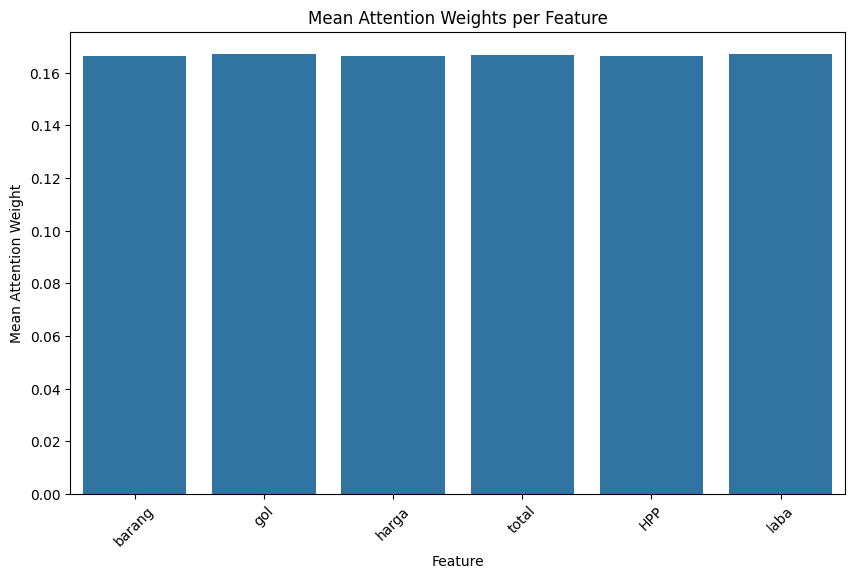

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import time
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(0)
np.random.seed(0)

### Begin of hyperparameters setting
data = "Aletheia"
dataset = "Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv"
delimiter = ';'
target = "qty"  # Label baru
#features = ['gol', 'harga', 'qty', 'total', 'HPP', 'laba']  # Fitur baru
#number_of_cols = len(features)
number_of_cols = 6 # jumlah fitur - target

input_window = 180           # input_window = previous time steps - output_window
output_window = 168
start_lr = 0.00005
epochs = 5
loss = "MAE"  # options MSE and MAE

nhidden=1024
num_layers=1
nhead=16
dropout=0.3
max_len_positional_encoding = 10000

scheduler_gamma = 0.87
batch_size = 1
step_size = 10
clip_grad_norm = 0.15

model_summary = True
model_save = False
with_Unet = True

### End of hyperparameters setting

if loss == "MSE":
    criterion = nn.MSELoss()
else:
    criterion = nn.L1Loss()

print("Multivariate")
print("data: " + data)
print("dataset: " + dataset)
print("target: " + target)
print("input_window: " + str(input_window))
print("output_window: " + str(output_window))
#print("batch_size: " + str(batch_size))
print("start_lr: " + str(start_lr))
print("epochs: " + str(epochs))
print("num_layers:" + str(num_layers))
print("withUNet: " + str(with_Unet))
print("Loss: " + loss)
print("===================================")

### Loading Dataset
train_data, val_data, test_data = get_aletheia_data(dataset=dataset, target=target, input_window=input_window, output_window=output_window, device=device, number_of_cols=number_of_cols)

### Model Transformer
if with_Unet == True:
    model = aletheia_UNet(nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout, in_channels=input_window, out_channels=output_window, max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols).to(device)
else:
    model = aletheia_noUNet(nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout, in_channels=input_window, out_channels=output_window, max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=scheduler_gamma)

if model_summary == True:
    print("=== Begin of model summary")
    print(model)
    print("=== End of model summary")
    print("===================================")

if model_save == True:
   what_to_save = {
   'epoch': epochs,
   'model': model.state_dict(),
   'optimizer': optimizer.state_dict(),
   'scheduler': scheduler.state_dict()
   }
   torch.save(what_to_save, "saved_models/checkpoint-mul-" + str(with_Unet) + "-" + dataset + "-" + str(input_window) + "-" + str(output_window) + ".pth")

### Begin of training and evaluating
print("=== Begin of training and evaluating")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_mul(model, optimizer, criterion, scheduler, clip_grad_norm, train_data, batch_size, epoch, epochs, input_window, output_window, number_of_cols, device)

    if (epoch % 5 == 0):
        pass
    else:
        val_loss = evaluate_mul(model, criterion, val_data, batch_size, input_window, output_window, number_of_cols, device)
        test_loss = evaluate_mul(eval_model=model, criterion=criterion, data_source=test_data, batch_size=batch_size, input_window=input_window, output_window=output_window, number_of_cols=number_of_cols, device=device)

    print('-' * 100)

    print('| end of epoch {:3d}/{} | time: {:5.2f}s | valid loss {:5.5f}'.format(epoch, epochs,(time.time() - epoch_start_time), val_loss))
    print('| end of epoch {:3d}/{} | time: {:5.2f}s | test loss {:5.5f}'.format(epoch, epochs,(time.time() - epoch_start_time), test_loss))
    print('-' * 100)

    scheduler.step()

print("final test_loss:")
print(evaluate_mul(model, criterion, test_data, batch_size, input_window, output_window, number_of_cols, device))

print("===================================")

### End of training and evaluating

### Visualisasi Feature Attention Weight
# Menyiapkan input tensor dari data training
features = ['barang', 'gol', 'harga', 'total', 'HPP', 'laba']
input_tensor = train_data[:number_of_cols, :input_window, :nhidden].clone().detach().float().to(device)
print("Bentuk input tensor sebelum attention:", input_tensor.shape)
print("===================================")

# Forward pass untuk mendapatkan attention weights
output, attn_weights = model.transformer_encoder(input_tensor)
print("Bentuk output dari transformer_encoder:", output.shape)
print("Bentuk attention weights:", attn_weights.shape)
print("===================================")

# Mengonversi attention weights ke NumPy
attention_weights_np = attn_weights.detach().cpu().numpy()
print("Bentuk Attention Weights:", attention_weights_np)
print("===================================")

# Menghitung rata-rata attention weights (dengan mempertimbangkan dimensi fitur)
mean_attention_weights = np.mean(attention_weights_np, axis=(0, 1))  # Adjust axis as needed

print("Panjang features:", len(features))
print("Panjang mean_attention_weights:", len(mean_attention_weights))
print("===================================")

print("Rata-Rata Attention Weights:")
print(mean_attention_weights)
print("===================================")

# Pastikan mean_attention_weights memiliki panjang yang sesuai dengan features
# Disini kami asumsikan mean_attention_weights memiliki panjang yang sesuai dengan batch_size atau sequence_length

# Jika mean_attention_weights tidak sesuai, Anda mungkin perlu mengubah cara menghitung atau memetakannya ke fitur

# Mengaitkan dengan fitur
df_attention = pd.DataFrame({
    'Feature': features,
    'Mean Attention Weight': np.repeat(mean_attention_weights, number_of_cols // len(mean_attention_weights))
})

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Mean Attention Weight', data=df_attention)
plt.title('Mean Attention Weights per Feature')
plt.xlabel('Feature')
plt.ylabel('Mean Attention Weight')
plt.xticks(rotation=45)
plt.show()



**Pengujian dan Evaluasi Hasil (Transformer_noUNet)**

Multivariate
data: Aletheia
dataset: Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv
target: qty
input_window: 180
output_window: 168
start_lr: 5e-05
epochs: 3
num_layers:1
withUNet: False
Loss: MAE
            barang  gol  harga  qty  total  HPP   laba
tanggal                                               
2022-07-13    1227    0  31000    1  31000    0  31000
2022-07-13    1232    0   3500    1   3500    0   3500
2022-07-13    1317    0  17500    1  17500    0  17500
2022-07-13     971    1   8500    1   8500    0   8500
2022-07-13    1820    1  21000    1  21000    0  21000
Fitur: Index(['barang', 'gol', 'harga', 'qty', 'total', 'HPP', 'laba'], dtype='object')
Bentuk data setelah pemuatan: (37811, 7)
Jumlah kolom yang digunakan: 6
Dataset setelah transformasi log:
              barang  gol      harga       qty      total       HPP       laba
tanggal                                                                       
2022-07-13  7.113956    0  10.341775  0.693147  10

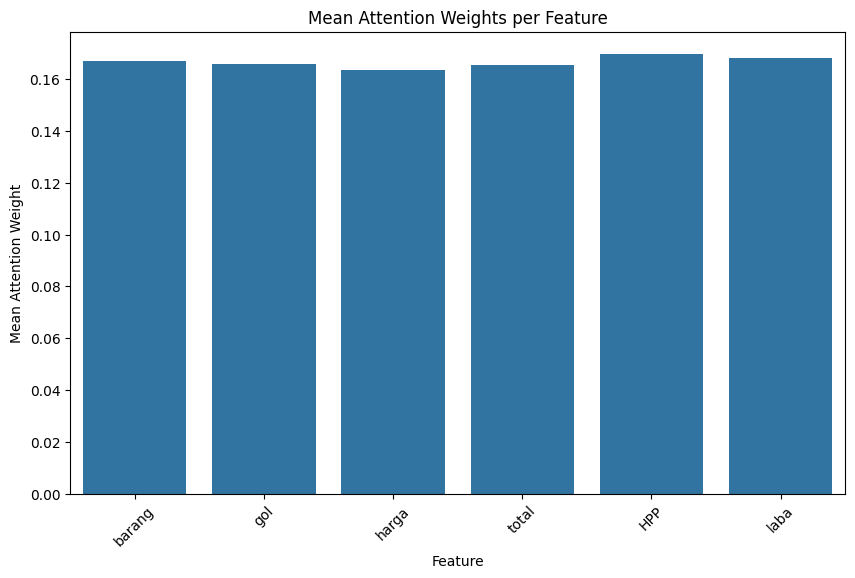

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import time
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(0)
np.random.seed(0)

### Begin of hyperparameters setting
data = "Aletheia"
dataset = "Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv"
delimiter = ';'
target = "qty"  # Label baru
#features = ['gol', 'harga', 'qty', 'total', 'HPP', 'laba']  # Fitur baru
#number_of_cols = len(features)
number_of_cols = 6 # jumlah fitur - target

input_window = 180           # input_window = previous time steps - output_window
output_window = 168
start_lr = 0.00005
epochs = 3
loss = "MAE"  # options MSE and MAE

nhidden=1024
num_layers=1
nhead=16
dropout=0.3
max_len_positional_encoding = 10000

scheduler_gamma = 0.87
batch_size = 1
step_size = 10
clip_grad_norm = 0.15

model_summary = True
model_save = False
with_Unet = False

### End of hyperparameters setting

if loss == "MSE":
    criterion = nn.MSELoss()
else:
    criterion = nn.L1Loss()

print("Multivariate")
print("data: " + data)
print("dataset: " + dataset)
print("target: " + target)
print("input_window: " + str(input_window))
print("output_window: " + str(output_window))
#print("batch_size: " + str(batch_size))
print("start_lr: " + str(start_lr))
print("epochs: " + str(epochs))
print("num_layers:" + str(num_layers))
print("withUNet: " + str(with_Unet))
print("Loss: " + loss)
print("===================================")

### Loading Dataset
train_data, val_data, test_data = get_aletheia_data(dataset=dataset, target=target, input_window=input_window, output_window=output_window, device=device, number_of_cols=number_of_cols)

### Model Transformer
if with_Unet == True:
    model = aletheia_UNet(nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout, in_channels=input_window, out_channels=output_window, max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols).to(device)
else:
    model = aletheia_noUNet(nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout, in_channels=input_window, out_channels=output_window, max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=scheduler_gamma)

if model_summary == True:
    print("=== Begin of model summary")
    print(model)
    print("=== End of model summary")
    print("===================================")

if model_save == True:
   what_to_save = {
   'epoch': epochs,
   'model': model.state_dict(),
   'optimizer': optimizer.state_dict(),
   'scheduler': scheduler.state_dict()
   }
   torch.save(what_to_save, "saved_models/checkpoint-mul-" + str(with_Unet) + "-" + dataset + "-" + str(input_window) + "-" + str(output_window) + ".pth")

### Begin of training and evaluating
print("=== Begin of training and evaluating")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_mul(model, optimizer, criterion, scheduler, clip_grad_norm, train_data, batch_size, epoch, epochs, input_window, output_window, number_of_cols, device)

    if (epoch % 5 == 0):
        pass
    else:
        val_loss = evaluate_mul(model, criterion, val_data, batch_size, input_window, output_window, number_of_cols, device)
        test_loss = evaluate_mul(eval_model=model, criterion=criterion, data_source=test_data, batch_size=batch_size, input_window=input_window, output_window=output_window, number_of_cols=number_of_cols, device=device)

    print('-' * 100)

    print('| end of epoch {:3d}/{} | time: {:5.2f}s | valid loss {:5.5f}'.format(epoch, epochs,(time.time() - epoch_start_time), val_loss))
    print('| end of epoch {:3d}/{} | time: {:5.2f}s | test loss {:5.5f}'.format(epoch, epochs,(time.time() - epoch_start_time), test_loss))
    print('-' * 100)

    scheduler.step()

print("final test_loss:")
print(evaluate_mul(model, criterion, test_data, batch_size, input_window, output_window, number_of_cols, device))

print("===================================")

## End of training and evaluating

## Visualisasi Feature Attention Weight
# Menyiapkan input tensor dari data training
features = ['barang', 'gol', 'harga', 'total', 'HPP', 'laba']
input_tensor = train_data[:number_of_cols, :input_window, :nhidden].clone().detach().float().to(device)
print("Bentuk input tensor sebelum attention:", input_tensor.shape)
print("===================================")

# Forward pass untuk mendapatkan attention weights
output, attn_weights = model.transformer_encoder(input_tensor)
print("Bentuk output dari transformer_encoder:", output.shape)
print("Bentuk attention weights:", attn_weights.shape)
print("===================================")

# Mengonversi attention weights ke NumPy
attention_weights_np = attn_weights.detach().cpu().numpy()
print("Bentuk Attention Weights:", attention_weights_np)
print("===================================")

# Menghitung rata-rata attention weights (dengan mempertimbangkan dimensi fitur)
mean_attention_weights = np.mean(attention_weights_np, axis=(0, 1))  # Adjust axis as needed

print("Panjang features:", len(features))
print("Panjang mean_attention_weights:", len(mean_attention_weights))
print("===================================")

print("Rata-Rata Attention Weights:")
print(mean_attention_weights)
print("===================================")

# Pastikan mean_attention_weights memiliki panjang yang sesuai dengan features
# Disini kami asumsikan mean_attention_weights memiliki panjang yang sesuai dengan batch_size atau sequence_length

# Jika mean_attention_weights tidak sesuai, Anda mungkin perlu mengubah cara menghitung atau memetakannya ke fitur

# Mengaitkan dengan fitur
df_attention = pd.DataFrame({
    'Feature': features,
    'Mean Attention Weight': np.repeat(mean_attention_weights, number_of_cols // len(mean_attention_weights))
})

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Mean Attention Weight', data=df_attention)
plt.title('Mean Attention Weights per Feature')
plt.xlabel('Feature')
plt.ylabel('Mean Attention Weight')
plt.xticks(rotation=45)
plt.show()



**PREDIKSI HASIL PENJUALAN**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import time
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(0)
np.random.seed(0)

### Begin of hyperparameters setting
data = "Aletheia"
dataset = "Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv"
delimiter = ';'
target = "qty"  # Label baru
#features = ['gol', 'harga', 'qty', 'total', 'HPP', 'laba']  # Fitur baru
#number_of_cols = len(features)
number_of_cols = 6 # jumlah fitur - target

input_window = 176           # input_window = previous time steps - output_window
output_window = 90
start_lr = 0.00005
epochs = 1
loss = "MAE"  # options MSE and MAE

nhidden=1056
num_layers=1
nhead=16
dropout=0.3
max_len_positional_encoding = 10000

scheduler_gamma = 0.87
batch_size = 1
step_size = 10
clip_grad_norm = 0.15

model_summary = True
model_save = False
with_Unet = True

### End of hyperparameters setting

if loss == "MSE":
    criterion = nn.MSELoss()
else:
    criterion = nn.L1Loss()

print("Multivariate")
print("data: " + data)
print("dataset: " + dataset)
print("target: " + target)
print("input_window: " + str(input_window))
print("output_window: " + str(output_window))
#print("batch_size: " + str(batch_size))
print("start_lr: " + str(start_lr))
print("epochs: " + str(epochs))
print("num_layers:" + str(num_layers))
print("withUNet: " + str(with_Unet))
print("Loss: " + loss)
print("===================================")

### Loading Dataset
train_data, val_data, test_data = get_aletheia_data(dataset=dataset, target=target, input_window=input_window, output_window=output_window, device=device, number_of_cols=number_of_cols)

### Model Transformer
if with_Unet == True:
    model = aletheia_UNet(nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout, in_channels=input_window, out_channels=output_window, max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols).to(device)
else:
    model = aletheia_noUNet(nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout, in_channels=input_window, out_channels=output_window, max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=scheduler_gamma)

if model_summary == True:
    print("=== Begin of model summary")
    print(model)
    print("=== End of model summary")
    print("===================================")

if model_save == True:
   what_to_save = {
   'epoch': epochs,
   'model': model.state_dict(),
   'optimizer': optimizer.state_dict(),
   'scheduler': scheduler.state_dict()
   }
   torch.save(what_to_save, "saved_models/checkpoint-mul-" + str(with_Unet) + "-" + dataset + "-" + str(input_window) + "-" + str(output_window) + ".pth")

### Begin of training and evaluating
print("=== Begin of training and evaluating")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_mul(model, optimizer, criterion, scheduler, clip_grad_norm, train_data, batch_size, epoch, epochs, input_window, output_window, number_of_cols, device)

    if (epoch % 5 == 0):
        pass
    else:
        val_loss = evaluate_mul(model, criterion, val_data, batch_size, input_window, output_window, number_of_cols, device)
        test_loss = evaluate_mul(eval_model=model, criterion=criterion, data_source=test_data, batch_size=batch_size, input_window=input_window, output_window=output_window, number_of_cols=number_of_cols, device=device)

    print('-' * 100)

    print('| end of epoch {:3d}/{} | time: {:5.2f}s | valid loss {:5.5f}'.format(epoch, epochs,(time.time() - epoch_start_time), val_loss))
    print('| end of epoch {:3d}/{} | time: {:5.2f}s | test loss {:5.5f}'.format(epoch, epochs,(time.time() - epoch_start_time), test_loss))
    print('-' * 100)

    scheduler.step()

print("final test_loss:")
print(evaluate_mul(model, criterion, test_data, batch_size, input_window, output_window, number_of_cols, device))

print("===================================")

### End of training and evaluating

### Prediksi 3 bulan ke depan
def predict_future(model, input_data, input_window, output_window, device):
    model.eval()
    with torch.no_grad():
        last_input = input_data[-input_window:].to(device)
        predictions = []

        for _ in range(output_window):
            print("Bentuk last_input sebelum unsqueeze: ", last_input.shape)
            # Jika last_input sudah 3D, tidak perlu unsqueeze
            if last_input.dim() == 2:  # Jika 2D, tambahkan dimensi batch
                last_input = last_input.unsqueeze(0)  # Menjadi [1, seq_length, feature_dim]
            elif last_input.dim() == 3:  # Jika 3D, tambahkan dimensi batch
                last_input = last_input.unsqueeze(0)  # Menjadi [1, batch_size, seq_length, feature_dim]
            print("Bentuk last_input setelah unsqueeze: ", last_input.shape)

            # Jika last_input sudah 4D, kita perlu mengubahnya menjadi 3D
            if last_input.dim() == 4:
                # Misalkan kita ingin menggabungkan dimensi 2 dan 3
                last_input = last_input.view(1* 176, 2, 1056)  # Mengubah menjadi [1, 176, 2 * 1056]

            output = model(last_input)

            if output.size(-1) != 6:
                raise RuntimeError(f"The output size is incorrect: {output.size()}")

            predictions.append(output.squeeze(0).cpu().numpy())

            # Update last_input untuk prediksi berikutnya
            last_input = torch.cat([last_input[:, :, 1:], output.unsqueeze(2)], dim=2)

        return np.array(predictions)

# Ambil data terakhir dari test_data untuk prediksi
input_data = test_data[:, -input_window:, :].clone().detach().float()  # Pilih semua fitur untuk timesteps input_window terakhir

# Lakukan prediksi untuk Januari hingga Maret 2025
future_predictions = predict_future(model, input_data, input_window, output_window, device)

# Tampilkan hasil prediksi
print("Prediksi 3 bulan ke depan:")
print(future_predictions)


Multivariate
data: Aletheia
dataset: Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv
target: qty
input_window: 176
output_window: 90
start_lr: 5e-05
epochs: 1
num_layers:1
withUNet: True
Loss: MAE
            barang  gol  harga  qty  total  HPP   laba
tanggal                                               
2022-07-13    1227    0  31000    1  31000    0  31000
2022-07-13    1232    0   3500    1   3500    0   3500
2022-07-13    1317    0  17500    1  17500    0  17500
2022-07-13     971    1   8500    1   8500    0   8500
2022-07-13    1820    1  21000    1  21000    0  21000
Fitur: Index(['barang', 'gol', 'harga', 'qty', 'total', 'HPP', 'laba'], dtype='object')
Bentuk data setelah pemuatan: (37811, 7)
Jumlah kolom yang digunakan: 6
Dataset setelah transformasi log:
              barang  gol      harga       qty      total       HPP       laba
tanggal                                                                       
2022-07-13  7.113956    0  10.341775  0.693147  10.3

KeyboardInterrupt: 

In [ ]:
def predict_future(model, input_data, input_window, output_window, device):
    model.eval()
    with torch.no_grad():
        last_input = input_data[-input_window:].to(device)
        predictions = []

        for _ in range(output_window):
            print("Bentuk last_input sebelum unsqueeze: ", last_input.shape)
            # Jika last_input sudah 3D, tidak perlu unsqueeze
            if last_input.dim() == 2:  # Jika 2D, tambahkan dimensi batch
                last_input = last_input.unsqueeze(0)  # Menjadi [1, seq_length, feature_dim]
            elif last_input.dim() == 3:  # Jika 3D, tambahkan dimensi batch
                last_input = last_input.unsqueeze(0)  # Menjadi [1, batch_size, seq_length, feature_dim]
            print("Bentuk last_input setelah unsqueeze: ", last_input.shape)

            # Jika last_input sudah 4D, kita perlu mengubahnya menjadi 3D
            if last_input.dim() == 4:
                # Misalkan kita ingin menggabungkan dimensi 2 dan 3
                last_input = last_input.view(1* 176, 2, 1056)  # Mengubah menjadi [1, 176, 2 * 1056]

            output = model(last_input)

            if output.size(-1) != 6:
                raise RuntimeError(f"The output size is incorrect: {output.size()}")

            predictions.append(output.squeeze(0).cpu().numpy())

            # Update last_input untuk prediksi berikutnya
            last_input = torch.cat([last_input[:, :, 1:], output.unsqueeze(2)], dim=2)

        return np.array(predictions)

# Ambil data terakhir dari test_data untuk prediksi
input_data = test_data[:, -input_window:, :].clone().detach().float()  # Pilih semua fitur untuk timesteps input_window terakhir

# Lakukan prediksi untuk Januari hingga Maret 2025
future_predictions = predict_future(model, input_data, input_window, output_window, device)

# Tampilkan hasil prediksi
print("Prediksi 3 bulan ke depan:")
print(future_predictions)

Bentuk last_input sebelum unsqueeze:  torch.Size([176, 2, 1056])
Bentuk last_input setelah unsqueeze:  torch.Size([1, 176, 2, 1056])
Shape of x: torch.Size([176, 2, 1056])
Shape of self.pe: torch.Size([10000, 1, 1056])


RuntimeError: The size of tensor a (176) must match the size of tensor b (2) at non-singleton dimension 0

**Visualisasi Hasil Prediksi terhadap Data Aktual**

In [ ]:
import torch
import numpy as np
import time
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(0)
np.random.seed(0)

# Hyperparameters
data = "Aletheia"
dataset = "Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv"
delimiter = ';'
target = "total"
number_of_cols = 6

input_window = 30
output_window = 24
start_lr = 0.00005
epochs = 5
loss = "MAE"

nhidden = 1024
num_layers = 1
nhead = 16
dropout = 0.3
max_len_positional_encoding = 10000

scheduler_gamma = 0.87
batch_size = 1
step_size = 10
clip_grad_norm = 0.15

model_summary = True
model_save = False
with_Unet = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if loss == "MSE":
    criterion = torch.nn.MSELoss()
else:
    criterion = torch.nn.L1Loss()

# Loading Dataset
train_data, val_data, test_data = get_aletheia_data(
    dataset=dataset, target=target, input_window=input_window, output_window=output_window,
    device=device, number_of_cols=number_of_cols
)

# Model Transformer
if with_Unet:
    model = aletheia_UNet(
        nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout,
        in_channels=input_window, out_channels=output_window,
        max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols
    ).to(device)
else:
    model = aletheia_noUNet(
        nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout,
        in_channels=input_window, out_channels=output_window,
        max_len_positional_encoding=max_len_positional_encoding, number_of_cols=number_of_cols
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=scheduler_gamma)

# Training Loop
print("=== Begin of training and evaluating")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_mul(model, optimizer, criterion, scheduler, clip_grad_norm, train_data, batch_size, epoch, epochs, input_window, output_window, number_of_cols, device)
    val_loss = evaluate_mul(model, criterion, val_data, batch_size, input_window, output_window, number_of_cols, device)
    test_loss = evaluate_mul(model, criterion, test_data, batch_size, input_window, output_window, number_of_cols, device)

    print('-' * 100)
    print('| end of epoch {:3d}/{} | time: {:5.2f}s | valid loss {:5.5f}'.format(epoch, epochs, (time.time() - epoch_start_time), val_loss))
    print('| end of epoch {:3d}/{} | time: {:5.2f}s | test loss {:5.5f}'.format(epoch, epochs, (time.time() - epoch_start_time), test_loss))
    print('-' * 100)

    scheduler.step()

print("final test_loss:")
print(evaluate_mul(model, criterion, test_data, batch_size, input_window, output_window, number_of_cols, device))
print("===================================")

# Evaluation Function to get actual and predicted values
def get_actual_vs_predicted(model, data_source, batch_size, input_window, output_window, number_of_cols, device):
    model.eval()
    actuals = []
    predictions = []

    with torch.no_grad():
        for i in range(0, len(data_source) - 1, batch_size):
            data, targets = get_batch_mul(data_source, i, batch_size, input_window, number_of_cols)
            output, _ = model(data)
            actuals.append(targets[-output_window:].cpu().numpy())
            predictions.append(output[-output_window:].cpu().numpy())

    return np.concatenate(actuals), np.concatenate(predictions)

# Get actual vs predicted values
actual, predicted = get_actual_vs_predicted(model, test_data, batch_size, input_window, output_window, number_of_cols, device)

# Flatten the arrays
actual = actual.flatten()
predicted = predicted.flatten()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual', color='blue')
plt.plot(predicted, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


            barang  gol  harga  qty  total  HPP   laba
tanggal                                               
2022-07-13    1227    0  31000    1  31000    0  31000
2022-07-13    1232    0   3500    1   3500    0   3500
2022-07-13    1317    0  17500    1  17500    0  17500
2022-07-13     971    1   8500    1   8500    0   8500
2022-07-13    1820    1  21000    1  21000    0  21000
Fitur: Index(['barang', 'gol', 'harga', 'qty', 'total', 'HPP', 'laba'], dtype='object')
Bentuk data setelah pemuatan: (37811, 7)
Jumlah kolom yang digunakan: 6
Dataset setelah transformasi log:
              barang  gol      harga       qty      total       HPP       laba
tanggal                                                                       
2022-07-13  7.113956    0  10.341775  0.693147  10.341775  0.693147  14.415512
2022-07-13  7.118016    0   8.160804  0.693147   8.160804  0.693147  14.400305
2022-07-13  7.184629    0   9.770013  0.693147   9.770013  0.693147  14.408076
2022-07-13  6.880384    1 

KeyboardInterrupt: 

**Visualisasi Attention pada Model Transformer**

            barang  gol  harga  qty  total  HPP   laba
tanggal                                               
2022-07-13    1227    0  31000    1  31000    0  31000
2022-07-13    1232    0   3500    1   3500    0   3500
2022-07-13    1317    0  17500    1  17500    0  17500
2022-07-13     971    1   8500    1   8500    0   8500
2022-07-13    1820    1  21000    1  21000    0  21000
Fitur: Index(['barang', 'gol', 'harga', 'qty', 'total', 'HPP', 'laba'], dtype='object')
Bentuk data setelah pemuatan: (37811, 7)
Jumlah kolom yang digunakan: 6
Dataset setelah transformasi log:
              barang  gol      harga       qty      total       HPP       laba
tanggal                                                                       
2022-07-13  7.113956    0  10.341775  0.693147  10.341775  0.693147  14.415512
2022-07-13  7.118016    0   8.160804  0.693147   8.160804  0.693147  14.400305
2022-07-13  7.184629    0   9.770013  0.693147   9.770013  0.693147  14.408076
2022-07-13  6.880384    1 

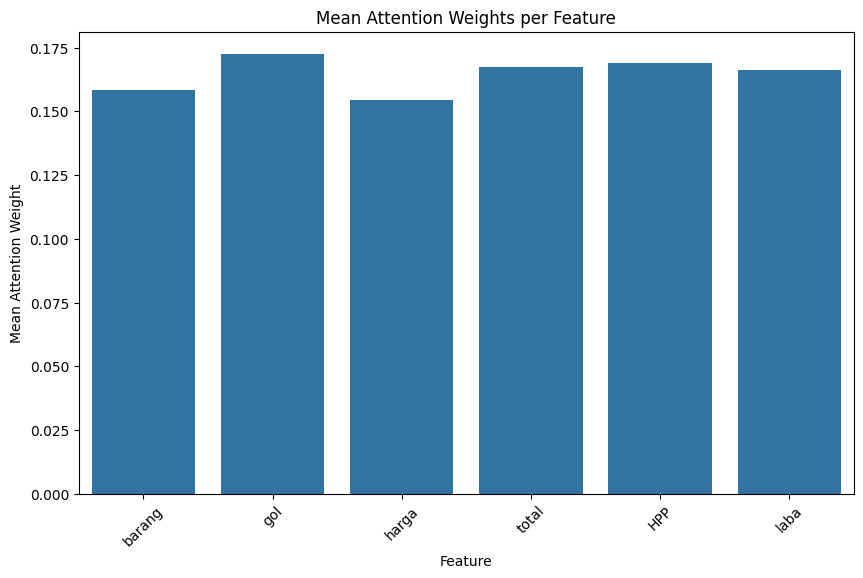

In [ ]:
# Menyiapkan input tensor dari data training
features = ['barang', 'gol', 'harga', 'total', 'HPP', 'laba']
number_of_cols = len(features)
input_window = 180
output_window = 168
batch_size = 1
nhidden = 1024
num_layers = 1
nhead = 16
dropout = 0.3
max_len_positional_encoding = 10000

# Menyiapkan perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data, val_data, test_data = get_aletheia_data(
    dataset=dataset, target="qty", input_window=input_window,
    output_window=output_window, device=device, number_of_cols=number_of_cols
)

# Model Transformer
with_Unet = True
if with_Unet:
    model = aletheia_UNet(
        nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout,
        in_channels=input_window, out_channels=output_window,
        max_len_positional_encoding=max_len_positional_encoding,
        number_of_cols=number_of_cols
    ).to(device)
else:
    model = aletheia_noUNet(
        nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout,
        in_channels=input_window, out_channels=output_window,
        max_len_positional_encoding=max_len_positional_encoding,
        number_of_cols=number_of_cols
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=scheduler_gamma)


# Menyiapkan input tensor dari data training
#features = ['barang', 'gol', 'harga', 'total', 'HPP', 'laba']
input_tensor = train_data[:number_of_cols, :input_window, :nhidden].clone().detach().float().to(device)
print("Bentuk input tensor sebelum attention:", input_tensor.shape)
print("===================================")

# Forward pass untuk mendapatkan attention weights
output, attn_weights = model.transformer_encoder(input_tensor)
print("Bentuk output dari transformer_encoder:", output.shape)
print("Bentuk attention weights:", attn_weights.shape)
print("===================================")

# Mengonversi attention weights ke NumPy
attention_weights_np = attn_weights.detach().cpu().numpy()
print("Bentuk Attention Weights:", attention_weights_np)
print("===================================")

# Menghitung rata-rata attention weights (dengan mempertimbangkan dimensi fitur)
mean_attention_weights = np.mean(attention_weights_np, axis=(0, 1))  # Adjust axis as needed

print("Panjang features:", len(features))
print("Panjang mean_attention_weights:", len(mean_attention_weights))
print("===================================")

print("Rata-Rata Attention Weights:")
print(mean_attention_weights)
print("===================================")

# Pastikan mean_attention_weights memiliki panjang yang sesuai dengan features
# Disini kami asumsikan mean_attention_weights memiliki panjang yang sesuai dengan batch_size atau sequence_length

# Jika mean_attention_weights tidak sesuai, Anda mungkin perlu mengubah cara menghitung atau memetakannya ke fitur

# Mengaitkan dengan fitur
df_attention = pd.DataFrame({
    'Feature': features,
    'Mean Attention Weight': np.repeat(mean_attention_weights, number_of_cols // len(mean_attention_weights))
})

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Mean Attention Weight', data=df_attention)
plt.title('Mean Attention Weights per Feature')
plt.xlabel('Feature')
plt.ylabel('Mean Attention Weight')
plt.xticks(rotation=45)
plt.show()


            barang  gol  harga  qty  total  HPP   laba
tanggal                                               
2022-07-13    1227    0  31000    1  31000    0  31000
2022-07-13    1232    0   3500    1   3500    0   3500
2022-07-13    1317    0  17500    1  17500    0  17500
2022-07-13     971    1   8500    1   8500    0   8500
2022-07-13    1820    1  21000    1  21000    0  21000
Fitur: Index(['barang', 'gol', 'harga', 'qty', 'total', 'HPP', 'laba'], dtype='object')
Bentuk data setelah pemuatan: (37811, 7)
Jumlah kolom yang digunakan: 6
Dataset setelah transformasi log:
              barang  gol      harga       qty      total       HPP       laba
tanggal                                                                       
2022-07-13  7.113956    0  10.341775  0.693147  10.341775  0.693147  14.415512
2022-07-13  7.118016    0   8.160804  0.693147   8.160804  0.693147  14.400305
2022-07-13  7.184629    0   9.770013  0.693147   9.770013  0.693147  14.408076
2022-07-13  6.880384    1 

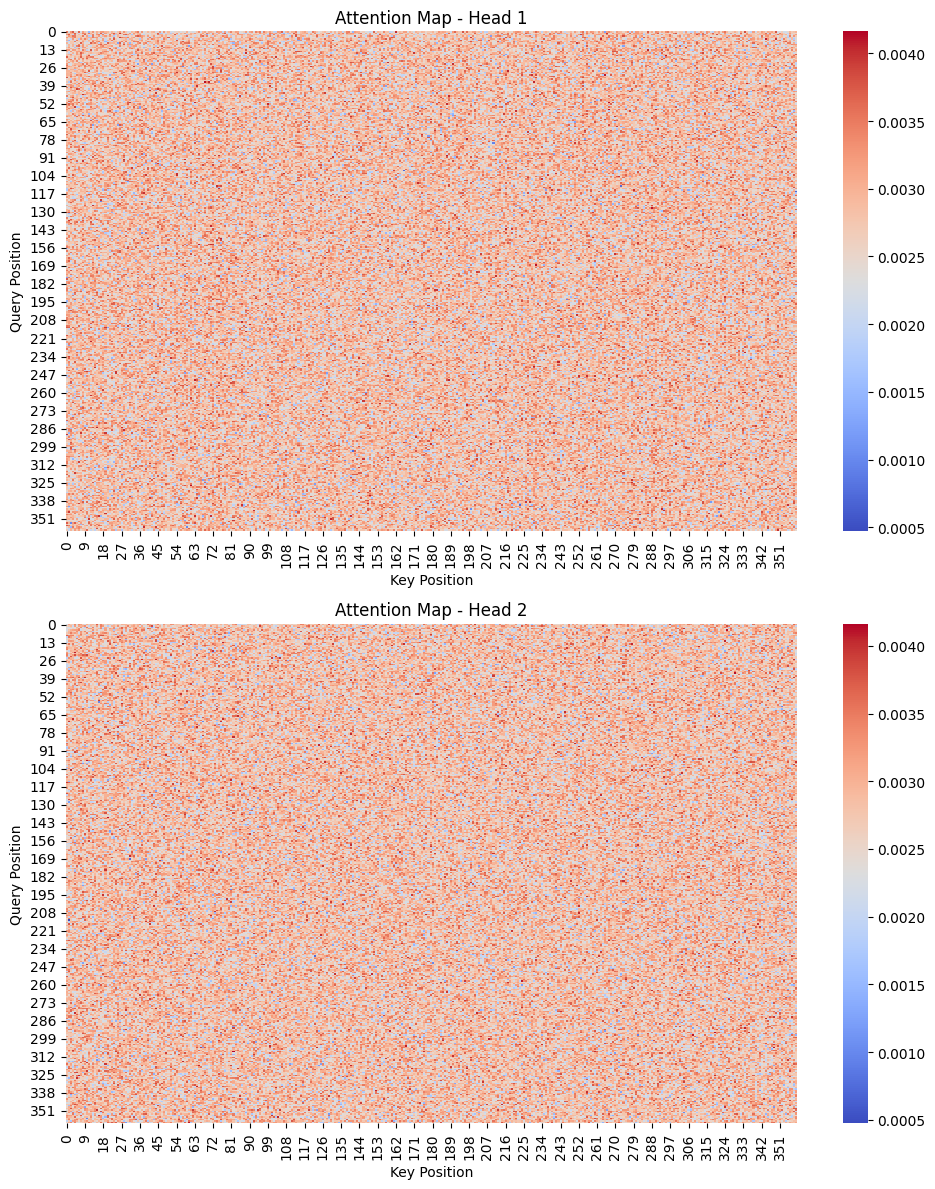

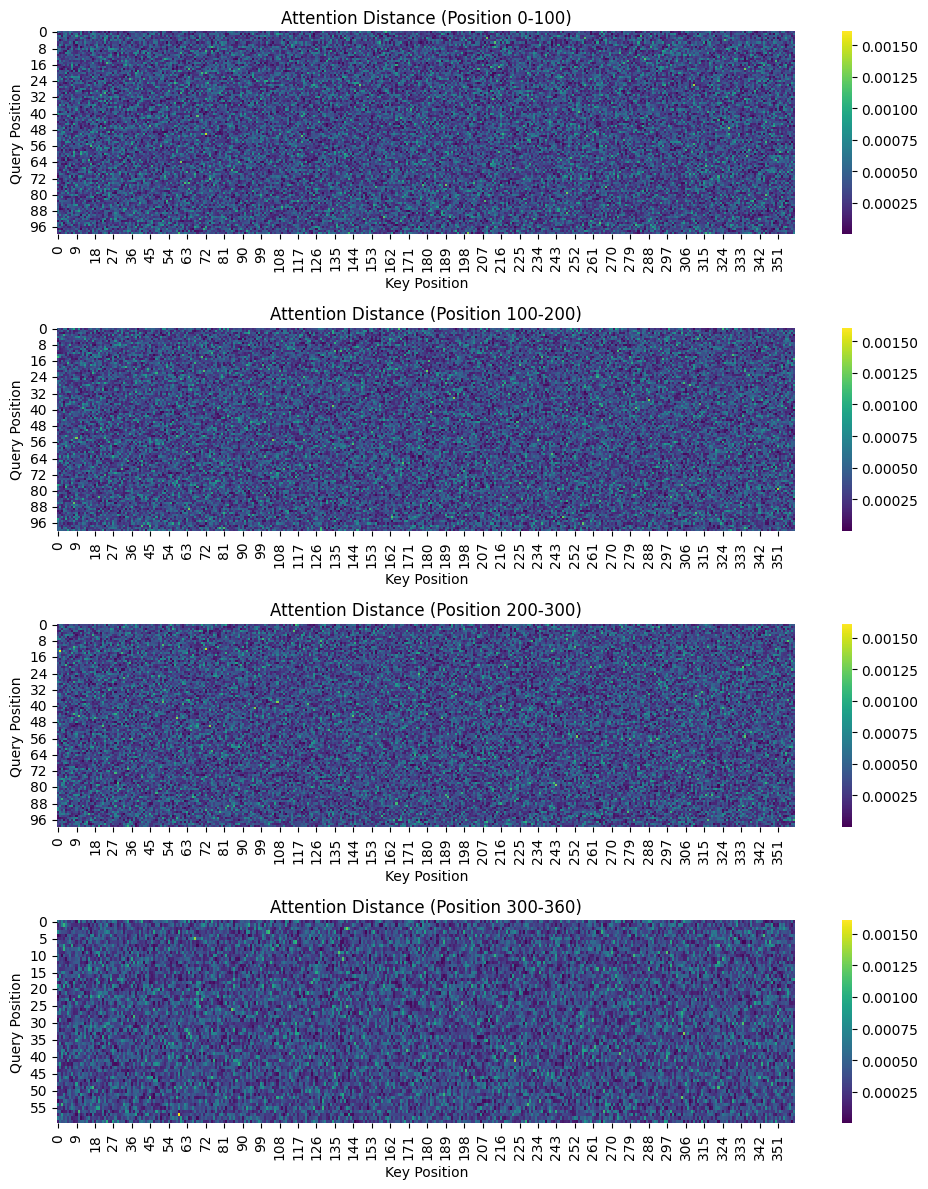

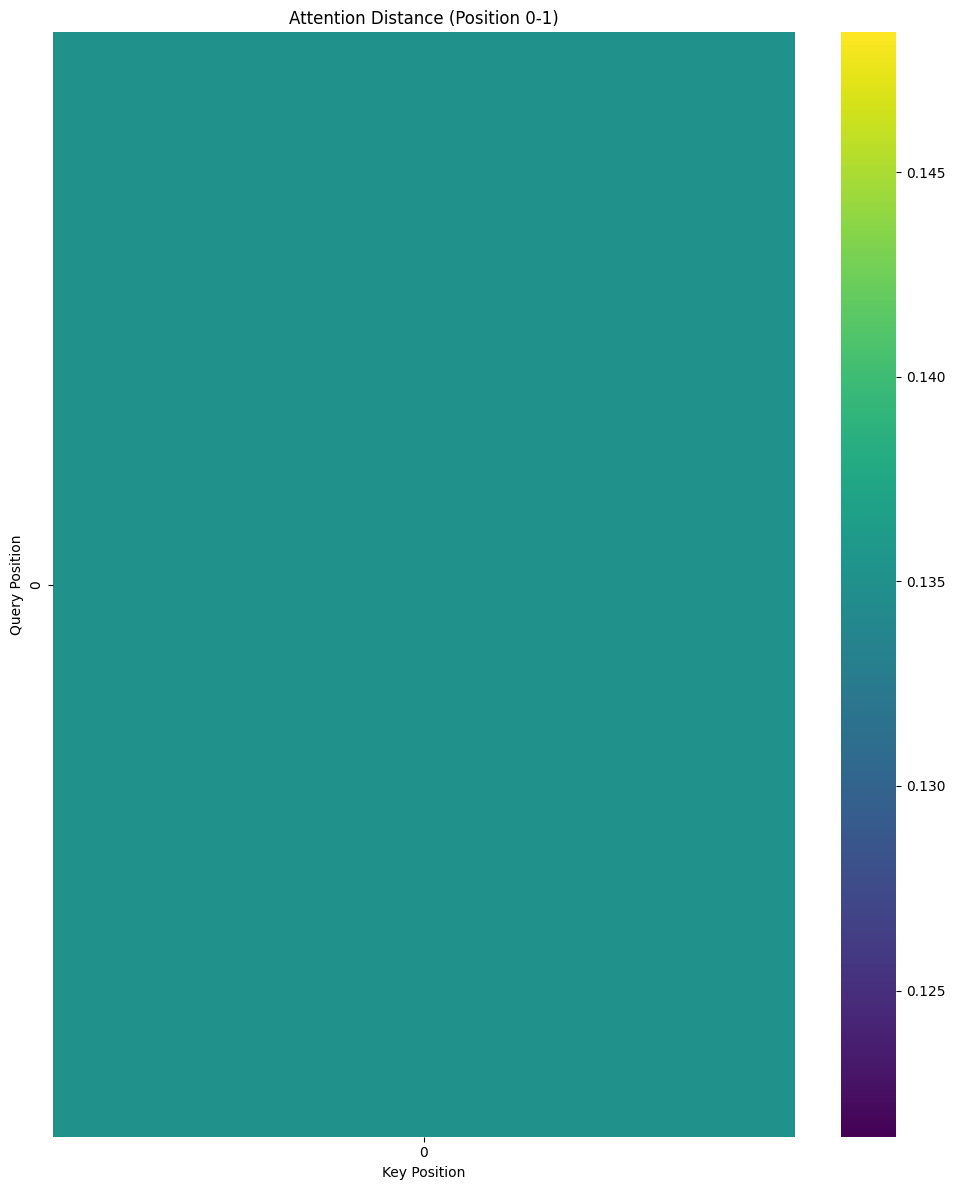

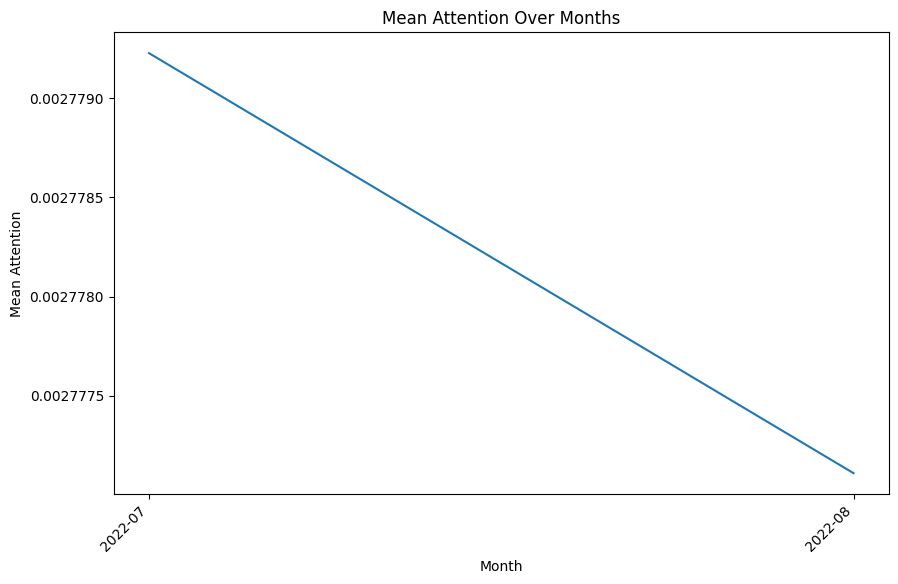

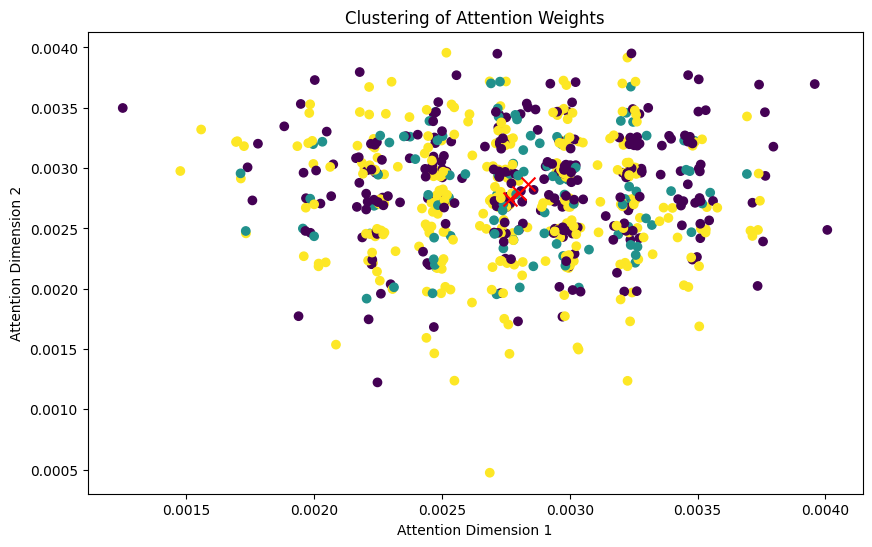

In [ ]:
from sklearn.cluster import KMeans

# Menyiapkan input tensor dari data training
features = ['barang', 'gol', 'harga', 'total', 'HPP', 'laba']
number_of_cols = len(features)
input_window = 360
output_window = 336
batch_size = 1
nhidden = 1024
num_layers = 1
nhead = 16
dropout = 0.3
max_len_positional_encoding = 10000

# Menyiapkan perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data, val_data, test_data = get_aletheia_data(
    dataset=dataset, target="qty", input_window=input_window,
    output_window=output_window, device=device, number_of_cols=number_of_cols
)

# Model Transformer
with_Unet = True
if with_Unet:
    model = aletheia_UNet(
        nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout,
        in_channels=input_window, out_channels=output_window,
        max_len_positional_encoding=max_len_positional_encoding,
        number_of_cols=number_of_cols
    ).to(device)
else:
    model = aletheia_noUNet(
        nhidden=nhidden, num_layers=num_layers, nhead=nhead, dropout=dropout,
        in_channels=input_window, out_channels=output_window,
        max_len_positional_encoding=max_len_positional_encoding,
        number_of_cols=number_of_cols
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=scheduler_gamma)

# Menggunakan train data sebagai input tensor
input_tensor = train_data[:input_window, :nhead, :nhidden].clone().detach().float().to(device)
print("Bentuk input tensor sebelum attention:", input_tensor.shape)
print("===================================")

# Forward pass untuk mendapatkan attention weights
output, attn_weights = model.transformer_encoder(input_tensor)
print("Bentuk output dari transformer_encoder:", output.shape)
print("Bentuk attention weights:", attn_weights.shape)
print("===================================")

# Transformasi attention weights
linear_layer = torch.nn.Linear(attn_weights.shape[-1], nhidden).to(device)
attention_input_tensor = linear_layer(attn_weights.view(-1, attn_weights.shape[-1])).view(batch_size, -1, nhidden)
print("Bentuk attention input tensor:", attention_input_tensor.shape)
print("===================================")

# Forward pass menggunakan attention weights sebagai input tensor
output2, attn_weights2 = model.transformer_encoder(attention_input_tensor)
print("Bentuk output dari transformer_encoder kedua:", output2.shape)
print("Bentuk attention weights kedua:", attn_weights2.shape)
print("===================================")

# Memisahkan attention weights ke dalam tabel terpisah
attention_weights_1 = attn_weights.detach().cpu().numpy()
attention_weights_2 = attn_weights2.detach().cpu().numpy()
df_attention_weights_1 = pd.DataFrame(attention_weights_1.reshape(-1, attention_weights_1.shape[-1]))
df_attention_weights_2 = pd.DataFrame(attention_weights_2.reshape(-1, attention_weights_2.shape[-1]))
print(df_attention_weights_1.head())
print(df_attention_weights_2.head())
print("===================================")

# Menghitung rata-rata bobot attention untuk setiap fitur
mean_attention_1 = np.mean(attention_weights_1, axis=(0, 1))
mean_attention_2 = np.mean(attention_weights_2, axis=(0, 1))
print("Rata-rata nilai attention pertama:", mean_attention_1)
print("Rata-rata nilai attention kedua:", mean_attention_2)
print("===================================")

# Menghitung jarak attention
attention_distance_1 = np.abs(attention_weights_1 - mean_attention_1)
attention_distance_2 = np.abs(attention_weights_2 - mean_attention_2)

# Visualisasi Attention pada Model Transformer dengan nilai min dan max disesuaikan
def visualize_attention(attn_weights):
    attention = attn_weights.detach().cpu().numpy()
    #print(attn_weights)

    vmin = attention.min()
    vmax = attention.max()

    plt.figure(figsize=(10, 12))
    n_heads = attention.shape[0]

    for i in range(n_heads):
        plt.subplot(n_heads, 1, i + 1)
        sns.heatmap(attention[i], cmap='coolwarm', cbar=True, vmin=vmin, vmax=vmax)
        plt.title(f'Attention Map - Head {i+1}')
        plt.xlabel('Key Position')
        plt.ylabel('Query Position')

    plt.tight_layout()
    plt.show()

# Visualisasi attention weights
visualize_attention(attn_weights)
#visualize_attention(attn_weights2)

# Visualisasi jarak attention
def visualize_attention_distance(attn_distance):
    distance = attn_distance.mean(axis=0)
    vmin = distance.min()
    vmax = distance.max()

    plt.figure(figsize=(10, 12))
    n_slices = distance.shape[0] // 100 + (1 if distance.shape[0] % 100 != 0 else 0)

    for i in range(n_slices):
        plt.subplot(n_slices, 1, i + 1)
        start_idx = i * 100
        end_idx = min((i + 1) * 100, distance.shape[0])
        sns.heatmap(distance[start_idx:end_idx, :], cmap='viridis', annot=False, vmin=vmin, vmax=vmax)
        plt.title(f'Attention Distance (Position {start_idx}-{end_idx})')
        plt.xlabel('Key Position')
        plt.ylabel('Query Position')

    plt.tight_layout()
    plt.show()

visualize_attention_distance(attention_distance_1)
visualize_attention_distance(attention_distance_2)

# Analisis Temporal Patterns Bulanan menggunakan kolom 'tanggal' dalam dataset
# Asumsikan kolom 'tanggal' ada dalam data dan berisi waktu transaksi
# Mengambil data dari kolom 'tanggal'
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Dataset Penjualan Apotek Atelhiea (Juli 2022 - Juni 2024).csv', delimiter=';')
dates = dataset['tanggal'][:len(train_data)]  # Pastikan 'tanggal' dalam format datetime

# Membuat DataFrame untuk mengaitkan dates dengan attention weights
df_attention = pd.DataFrame(np.mean(attention_weights_1, axis=(0, 2)), columns=['Mean Attention'])
df_attention['Date'] = dates
# Convert 'Date' column to datetime objects, specifying dayfirst=True
df_attention['Date'] = pd.to_datetime(df_attention['Date'], dayfirst=True)

df_attention['Month'] = df_attention['Date'].dt.to_period('M')

# Mengelompokkan berdasarkan bulan dan menghitung rata-rata attention
monthly_attention = df_attention.groupby('Month')['Mean Attention'].mean().reset_index()

# Convert 'Month' column to strings for plotting
monthly_attention['Month'] = monthly_attention['Month'].astype(str) # Convert Period objects to strings

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_attention, x='Month', y='Mean Attention')
plt.title('Mean Attention Over Months')
plt.xlabel('Month')
plt.ylabel('Mean Attention')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.show()

# Analisis Cluster
# Reshape attention weights untuk clustering
attention_flat = attention_weights_1.reshape(-1, attention_weights_1.shape[-1])

# Melakukan clustering dengan K-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(attention_flat)
clusters = kmeans.labels_

# Menghitung centroid untuk visualisasi
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 6))
plt.scatter(attention_flat[:, 0], attention_flat[:, 1], c=clusters, cmap='viridis', marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.title('Clustering of Attention Weights')
plt.xlabel('Attention Dimension 1')
plt.ylabel('Attention Dimension 2')
plt.show()
